In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import timeit
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d
from scipy.stats import entropy
# Ignore excessive warnings
#import logging
#logging.propagate = False 
#logging.getLogger().setLevel(logging.ERROR)

# WandB – Import the wandb library
#import wandb
import SimpleITK as sitk
from joblib import Parallel, delayed
from functools import partial
from sklearn import metrics
from collections import Counter

In [12]:
path = 'C:/Users/bruno/OneDrive/Área de Trabalho/Mestrado/Pesquisa/Dataset_BUSI_with_GT/'

In [5]:
def num (image) :
    
    val = 0
    
    for i in range(len(image)) :
        if image[i] == '(' :
            while True :
                i += 1
                if image[i] == ')' :
                    break
                val = (val*10) + int(image[i])
            break
    
    return val

In [6]:
#x for images 
#y for masks
#t for target"label"
X_b, y_b = np.zeros((437, 128, 128, 1)), np.zeros((437, 128, 128, 1))
X_n, y_n = np.zeros((133, 128, 128, 1)), np.zeros((133, 128, 128, 1))
X_m, y_m= np.zeros((210, 128, 128, 1)), np.zeros((210, 128, 128, 1))

In [13]:
for i, tumor_type in enumerate(os.listdir(path)) :
    for image in os.listdir(path+tumor_type+'/') :
        p = os.path.join(path+tumor_type, image)
        img = cv2.imread(p,cv2.IMREAD_GRAYSCALE)           # read image as  grayscale
    
        if image[-5] == ')' :
            
            img = cv2.resize(img,(128,128))
            
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                X_b[num(image)-1]+= np.array(pil_img).reshape(128,128,1)  
            if image[0] == 'n' :                           
                X_n[num(image)-1]+= np.array(pil_img).reshape(128,128,1)  
            if image[0] == 'm' :
                X_m[num(image)-1]+= np.array(pil_img).reshape(128,128,1)  
        else :
            img = cv2.resize(img,(128,128))
            pil_img = Image.fromarray (img)
            
            if image[0] == 'b' :
                y_b[num(image)-1]+= np.array(pil_img).reshape(128,128,1)    
            if image[0] == 'n' :                           
                y_n[num(image)-1]+= np.array(pil_img).reshape(128,128,1)  
            if image[0] == 'm' :
                y_m[num(image)-1]+= np.array(pil_img).reshape(128,128,1)  

In [14]:
X = np.concatenate((X_b, X_n, X_m), axis = 0)
y = np.concatenate((y_b, y_n, y_m), axis = 0)

In [15]:
print(X.shape)
print(y.shape)

(780, 128, 128, 1)
(780, 128, 128, 1)


In [16]:
def convertToOneChannel(img):
    im=np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])
    i=cv2.resize(im, (128, 128))
    return i

In [17]:
def convertToThreeChannel(img):
    b_np= np.array(img)
    g_np= np.array(img)
    r_np= np.array(img)
    final_img = np.dstack([b_np, g_np, r_np]).astype(np.uint8)
    return np.array(final_img)

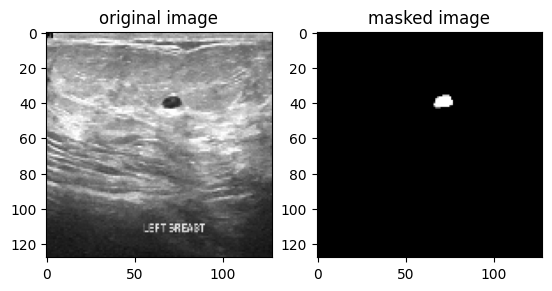

In [18]:
img=convertToThreeChannel(X[0])
mask=convertToThreeChannel(y[0])
plt.figure
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("original image")
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("masked image")
plt.show()

In [19]:
actual=[]
mask=[]

for i in X:
    horizontal_flip = cv2.flip(i, 1)
    vertical_horizontal_flip = cv2.flip(i, -1)
    imagerotate = cv2.rotate(i, cv2.ROTATE_180) 
    imagerotate1 = cv2.rotate(i, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imagerotate2 = cv2.rotate(i, cv2.ROTATE_90_CLOCKWISE)
    actual.append(horizontal_flip)
    actual.append(vertical_horizontal_flip)
    actual.append(imagerotate)
    actual.append(imagerotate1)
    actual.append(imagerotate2)
    
for j in y:
    horizontal_flip_mask = cv2.flip(j, 1)
    vertical_horizontal_flip_mask = cv2.flip(j, -1)
    imagerotate_mask1 = cv2.rotate(j, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imagerotate_mask = cv2.rotate(j, cv2.ROTATE_180)
    imagerotate_mask2 = cv2.rotate(j, cv2.ROTATE_90_CLOCKWISE)
    mask.append(horizontal_flip_mask)
    mask.append(vertical_horizontal_flip_mask)
    mask.append(imagerotate_mask)
    mask.append(imagerotate_mask1)
    mask.append(imagerotate_mask2)

In [20]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3900, 128, 128)
(3900, 128, 128)


In [21]:
actual=actual/255
mask=mask/255
print(mask.max())
print(mask.min())

2.0
0.0


In [22]:
mask[mask > 1.0] = 1.0

In [23]:
print(mask.max())
print(mask.min())

1.0
0.0


In [24]:
mask=np.array(mask)
actual=np.array(actual)
print(actual.shape)
print(mask.shape)

(3900, 128, 128)
(3900, 128, 128)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(actual, mask, test_size = 0.15, random_state = 1)

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.10, random_state = 1)

In [27]:
print(X_train.shape)
print(X_test.shape)

(2983, 128, 128)
(585, 128, 128)


In [28]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)
    
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[32,64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    assert preds.shape == x.shape
if __name__ == "__main__":
    test()

c:\Users\bruno\anaconda3\envs\research\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [29]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(X_train,y_train,X_val,y_val,batch_size,num_workers=4,pin_memory=True):
    
    X_train_tensor = torch.Tensor(X_train.reshape(-1,1,128,128))
    y_train_tensor = torch.Tensor(y_train.reshape(-1,1,128,128))
    
    train_loader = DataLoader(TensorDataset(X_train_tensor,y_train_tensor),
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,) 

    X_val_tensor = torch.Tensor(X_val.reshape(-1,1,128,128))
    y_val_tensor = torch.Tensor(y_val.reshape(-1,1,128,128))
    
    val_loader = DataLoader(TensorDataset(X_val_tensor,y_val_tensor),
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,) 

    return train_loader, val_loader    

def get_loaders_test(X_test,y_test):
    
    X_test_tensor = torch.Tensor(X_test.reshape(-1,1,128,128))
    y_test_tensor = torch.Tensor(y_test.reshape(-1,1,128,128))
    
    test_loader = DataLoader(TensorDataset(X_test_tensor,y_test_tensor)) 

    return test_loader   

def check_accuracy(loader, model, loss_fn, epoch, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += dice_coef(preds, y)
    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    
    print(f"Dice score: {dice_score/len(loader)}")
    
    wandb.log({ "val_loss": loss_fn(preds, y), "val_dice": dice_score/len(loader)}, step=epoch, commit = True)
    model.train()

def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y, f"{folder}{idx}.png")

    model.train()
    
def dice_coef(preds,target):
    preds = preds>0.5
    intersect = (preds * target).sum()
    union = (preds + target).sum()
    if union == 0:
        return 1.0
    else:
        return (2*intersect/union)

In [32]:
def inference(hyperparameters,i_model, X_i, y_i):

    model = UNET(in_channels=1, out_channels=1).to(hyperparameters['device'])


    test_loader = get_loaders_test(X_i,y_i)
    load_checkpoint(torch.load("model_%s.pth.tar"%i_model, map_location = hyperparameters['device']), model)
    device=hyperparameters['device']
    tests = []
    tests_pred = []
    tests_pred_bin = []
    x_tests = []
    count_test = 0
    total_dice = 0
    
    model.eval()
    for idx, (x, y) in enumerate(test_loader):
        dice_score = 0
        x = x.to(device=device)
        y = y.to(device=device)
        with torch.no_grad():
            test_preds = torch.sigmoid(model(x))
            test_preds_bin = (test_preds > 0.5).float()
        tests.append(y)
        tests_pred.append(test_preds)
        tests_pred_bin.append(test_preds_bin)
        x_tests.append(x)
        dice_score += dice_coef(test_preds_bin, y)
        total_dice += dice_score
        #wandb.log({"dice_per_test": dice_score}, step=count_test)
        count_test +=1
        
    return x_tests, tests, tests_pred, tests_pred_bin

In [33]:
# Hyperparameters etc.
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 5e-5
BATCH_SIZE = 32
NUM_EPOCHS = 10
NUM_WORKERS = 2
IMAGE_HEIGHT = 128  
IMAGE_WIDTH = 128  
PIN_MEMORY = True
LOAD_MODEL = False
n_ensembles = 5
hyperparameters= dict(epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, num_workers=NUM_WORKERS, device=DEVICE, pin_memory=PIN_MEMORY, load_model=LOAD_MODEL )

x_tests_e = []
tests_e = []
tests_pred_e = []
tests_pred_bin_e = []
for i_model in range(n_ensembles):
        x_tests, tests, tests_pred, tests_pred_bin = inference(hyperparameters, i_model,X_test, y_test)
        x_tests_e.append(x_tests)
        tests_e.append(tests)
        tests_pred_np = [t_pred.cpu().numpy().reshape(128,128) for t_pred in tests_pred]
        if i_model == 0 :
            tests_pred_e = tests_pred_np
        else:
            tests_pred_e = np.vstack((tests_pred_e, tests_pred_np))
        tests_pred_bin_np = [t_pred_bin.cpu().numpy().reshape(128,128) for t_pred_bin in tests_pred_bin]
        if i_model == 0 :
            tests_pred_bin_e = tests_pred_bin_np
        else:
            tests_pred_bin_e = np.vstack((tests_pred_bin_e, tests_pred_bin_np))

=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint


In [34]:
x_vals_e = []
vals_e = []
vals_pred_e = []
vals_pred_bin_e = []
for i_model in range(n_ensembles):
        x_vals, vals, vals_pred, vals_pred_bin = inference(hyperparameters, i_model,X_val, y_val)
        x_vals_e.append(x_vals)
        vals_e.append(vals)
        vals_pred_np = [v_pred.cpu().numpy().reshape(128,128) for v_pred in vals_pred]
        if i_model == 0 :
            vals_pred_e = vals_pred_np
        else:
            vals_pred_e = np.vstack((vals_pred_e, vals_pred_np))
        vals_pred_bin_np = [v_pred_bin.cpu().numpy().reshape(128,128) for v_pred_bin in vals_pred_bin]
        if i_model == 0 :
            vals_pred_bin_e = vals_pred_bin_np
        else:
            vals_pred_bin_e = np.vstack((vals_pred_bin_e, vals_pred_bin_np))

=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint


In [35]:
#função para calcular o parametro r para a dice norm
def r_calc(gt):
    
    return np.sum(gt) /len(gt.flatten())

r_list = [r_calc(i) for i in y_train]
r = np.mean(r_list, axis=0)
print(r)

0.07830069136604054


In [36]:
#função dice norm
def dice_norm_metric(predictions, ground_truth, r = r, threshold1 = 0.5, threshold2 = 0.5):
    """
    Compute Normalised Dice Coefficient (nDSC), 
    False positive rate (FPR),
    False negative rate (FNR) for a single example.
    
    Args:
      ground_truth: `numpy.ndarray`, binary ground truth segmentation target,
                     with shape [H, W, D].
      predictions:  `numpy.ndarray`, binary segmentation predictions,
                     with shape [H, W, D].
    Returns:
      Normalised dice coefficient (`float` in [0.0, 1.0]),
      False positive rate (`float` in [0.0, 1.0]),
      False negative rate (`float` in [0.0, 1.0]),
      between `ground_truth` and `predictions`.
    """

    # Cast to float32 type
    gt = ground_truth>threshold2
    gt = gt.astype("float32")
    seg = predictions>threshold1
    seg = seg.astype("float32")
    
    im_sum = np.sum(seg) + np.sum(gt)
    if im_sum == 0:
        return 1.0
    else:
        if np.sum(gt) == 0:
            k = 1.0
        else:
            k = (1 - r) * np.sum(gt) / (r * (len(gt.flatten()) - np.sum(gt)))
        tp = np.sum(seg[gt == 1])
        fp = np.sum(seg[gt == 0])
        fn = np.sum(gt[seg == 0])
        fp_scaled = k * fp
        dsc_norm = 2. * tp / (fp_scaled + 2. * tp + fn)
        return dsc_norm

In [37]:
def soft_dice_norm_metric(pred, target, r=0.0783):
    """
    Compute Normalised Dice Coefficient (nDSC), 
    False positive rate (FPR),
    False negative rate (FNR) for a single example.
    
    Args:
      target: `numpy.ndarray`, binary ground truth segmentation target,
                     with shape [H, W, D].
      pred:  `numpy.ndarray`, binary segmentation predictions,
                     with shape [H, W, D].
    Returns:
      Normalised dice coefficient (`float` in [0.0, 1.0]),
      False positive rate (`float` in [0.0, 1.0]),
      False negative rate (`float` in [0.0, 1.0]),
      between `ground_truth` and `predictions`.
    """
    smooth = 0.0

    # Cast to float32 type
    gt = target.astype("float32")
    seg = pred.astype("float32")

    im_sum = np.sum(seg) + np.sum(gt)
    if im_sum == 0:
        return 1.0
    else:
        if np.sum(gt) == 0:
            k = 1.0
        else:
            k = (1 - r) * np.sum(gt) / (r * (len(gt.flatten()) - np.sum(gt)))
        tp = np.sum(seg * gt)
        fp = np.sum(seg * (1 - gt))
        fn = np.sum((1 - seg) * gt)
        fp_scaled = k * fp
        dsc_norm = (2. * tp + smooth) / (fp_scaled + 2. * tp + fn + smooth)

        return dsc_norm

In [38]:
#função para realizar a curva de retenção
def compute_retention_curve(confidence: np.ndarray, dices: np.ndarray):
    ordering = confidence.argsort()

    scores_ = confidence[ordering]
    dices_ = dices[ordering]

    retention_percentage = list()
    retention_score = list()
    for i in range(len(scores_) + 1):
        retention_percentage.append(i / len(scores_))
        ret_dices_ = np.ones_like(dices_)
        ret_dices_[:i] = dices_[:i]
        retention_score.append(np.mean(ret_dices_))

    return retention_percentage, retention_score

In [163]:
def rc_curve(confidence, dice, expert=False, expert_cost=0):
    error = 1 - dice

    error = np.array(error).reshape(-1)
    confidence = np.array(confidence).reshape(-1)
    n = len(error)
    assert len(confidence) == n
    desc_sort_indices = confidence.argsort()[::-1]
    error = error[desc_sort_indices]
    confidence = confidence[desc_sort_indices]
    idx = np.r_[np.where(np.diff(confidence))[0], n-1]
    thresholds = confidence[idx]
    coverages = (1 + idx)/n
    risks = np.cumsum(error)[idx]/n
    if expert:
        if np.any(expert_cost):
            expert_cost = np.array(expert_cost).reshape(-1)
            if expert_cost.size == 1:
                risks += (1 - coverages)*expert_cost
            else:
                assert len(expert_cost) == n
                expert_cost = np.cumsum(expert_cost)
                expert_cost = expert_cost[-1] - expert_cost
                risks += expert_cost[idx]/n
    else:
        risks /= coverages
    
    return coverages, risks, thresholds

In [40]:
#funções de medidas de incertezas
def entropy_of_expected(probs, epsilon=1e-10):
    """
    :param probs: array [num_models, num_voxels_X, num_voxels_Y, num_classes]
    :return: array [num_voxels_X, num_voxels_Y]
    """
    mean_probs = np.mean(probs, axis=0)
    log_probs = -np.log(mean_probs + epsilon)
    return np.sum(mean_probs * log_probs, axis=-1)

def expected_entropy(probs, epsilon=1e-10):
    """
    :param probs: array [num_models, num_voxels_X, num_voxels_Y, num_voxels_Z, num_classes]
    :return: array [num_voxels_X, num_voxels_Y, num_voxels_Z,]
    """
    log_probs = -np.log(probs + epsilon)
    return np.mean(np.sum(probs * log_probs, axis=-1), axis=0)


def ensemble_uncertainties_classification(probs, epsilon=1e-10):
    """
    :param probs: array [num_models, num_voxels_X, num_voxels_Y, num_voxels_Z, num_classes]
    :return: Dictionary of uncertainties
    """
    mean_probs = np.mean(probs, axis=0)
    mean_lprobs = np.mean(np.log(probs + epsilon), axis=0)
    conf = np.max(mean_probs, axis=-1)

    eoe = entropy_of_expected(probs, epsilon)
    exe = expected_entropy(probs, epsilon)

    mutual_info = eoe - exe

    epkl = -np.sum(mean_probs * mean_lprobs, axis=-1) - exe

    uncertainty = {'confidence': conf,
                   'entropy_of_expected': eoe,
                   'expected_entropy': exe,
                   'mutual_information': mutual_info,
                   'epkl': epkl,
                   'reverse_mutual_information': epkl - mutual_info,
                   }

    return uncertainty

In [41]:
tests_pred_e = tests_pred_e.reshape(n_ensembles,-1,128,128)
test_pred_means = np.mean(tests_pred_e, axis=0)
tests_uncert = np.concatenate((tests_pred_e.reshape(n_ensembles,-1,128,128,1), 1-tests_pred_e.reshape(n_ensembles,-1,128,128,1)), axis = -1)

In [42]:
vals_pred_e = vals_pred_e.reshape(n_ensembles,-1,128,128)
val_pred_means = np.mean(vals_pred_e, axis=0)
vals_uncert = np.concatenate((vals_pred_e.reshape(n_ensembles,-1,128,128,1), 1-vals_pred_e.reshape(n_ensembles,-1,128,128,1)), axis = -1)

In [43]:
norm_dices_test = list()
for ind, p in enumerate(test_pred_means):
    norm_dices_test.append(dice_norm_metric(p,tests[ind].cpu().numpy().reshape(128,128)))
norm_dices_test = np.asarray(norm_dices_test)

In [60]:
norm_dices_val = list()
for ind, v in enumerate(val_pred_means):
    norm_dices_val.append(dice_norm_metric(v,vals[ind].cpu().numpy().reshape(128,128)))
norm_dices_val = np.asarray(norm_dices_val)

In [44]:
def aula_ndsc_heads_mean_func(pred,pred_mean):
    aula_ndsc_mean = []
    for j in range(pred.shape[1]):
        aula_curve = [dice_norm_metric(pred[i][j],pred_mean[j]) for i in range(pred.shape[0]-1,-1,-1)]
        aula_ndsc_mean.append(np.mean(aula_curve))
    aula_ndsc_mean = np.array(aula_ndsc_mean)
    return aula_ndsc_mean

In [45]:
def dice_loss(y_pred, y_true):
    intersection = np.sum(y_true * y_pred)
    sum_of_squares_pred = np.sum(np.square(y_pred))
    sum_of_squares_true = np.sum(np.square(y_true))
    if sum_of_squares_pred == sum_of_squares_true and sum_of_squares_pred == 0:
        dice =1
    else:
        dice = 1 - (2 * intersection) / (sum_of_squares_pred + sum_of_squares_true)
    return dice

In [46]:
def var_score(y, y_mean):
    n = y_mean.size
    return np.sum(np.square(y-y_mean))/(n-1)

In [47]:
def aula_dice_loss_mean_func(pred,pred_mean):
    aula_ndsc_mean = []
    for j in range(pred.shape[1]):
        aula_curve = [dice_loss(pred[i][j], pred_mean[j]) for i in range(pred.shape[0]-1,-1,-1)]
        aula_ndsc_mean.append(np.mean(aula_curve))
    aula_ndsc_mean = np.array(aula_ndsc_mean)
    return aula_ndsc_mean

In [48]:
def aula_soft_ndice_loss_mean_func(pred,pred_mean):
    aula_ndsc_mean = []
    for j in range(pred.shape[1]):
        aula_curve = [soft_dice_norm_metric(pred[i][j], pred_mean[j]) for i in range(pred.shape[0]-1,-1,-1)]
        aula_ndsc_mean.append(np.mean(aula_curve))
    aula_ndsc_mean = np.array(aula_ndsc_mean)
    return aula_ndsc_mean

In [49]:
def compute_var_func(pred,pred_mean):
    var = []
    for j in range(pred.shape[1]):
        var.append(var_score(pred[:,j],pred_mean[j]))
    var = np.array(var)
    return var

In [50]:
aula_soft_dice_loss_mean = aula_soft_ndice_loss_mean_func(tests_pred_e,test_pred_means)

In [51]:
aula_dice_loss_mean = aula_dice_loss_mean_func(tests_pred_e,test_pred_means)

In [52]:
aula_ndsc_mean = aula_ndsc_heads_mean_func(tests_pred_e,test_pred_means)

In [53]:
var_uncert = compute_var_func(tests_pred_e,test_pred_means)

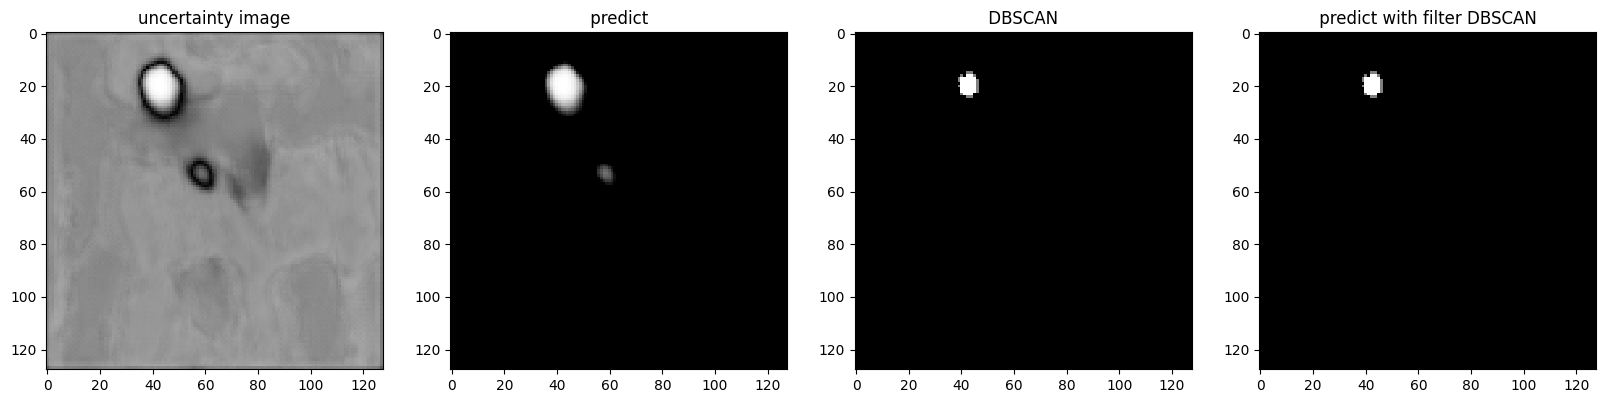

In [54]:
from sklearn.cluster import DBSCAN, KMeans
index = 2
uncert_max = ensemble_uncertainties_classification(tests_uncert[:,:,:,:,:])['confidence'][index]

# Aplicar o algoritmo DBSCAN
dbscan = DBSCAN(eps=0.01, min_samples=16)
#dbscan = KMeans(n_clusters=2)
norm_uncert = uncert_max/0.5-1
labels = dbscan.fit_predict((norm_uncert*(test_pred_means[index]>0.5)).reshape(-1,1))
rows, cols = uncert_max.shape
all_pixels = [(i, j) for i in range(rows) for j in range(cols)]
# Visualizar os resultados
output_image = np.zeros((rows, cols))
for i, label in enumerate(labels):
    x, y = all_pixels[i]
    if label != -1:  # Ignorar pontos de ruído
        #output_image[x, y] = uncert_max[x, y]
        output_image[x, y] = label
        

plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
plt.imshow(uncert_max,interpolation='nearest',cmap='gray')
plt.title("uncertainty image")
plt.subplot(1,4,2)
plt.imshow(norm_uncert*(test_pred_means[index]>0.5),interpolation='nearest',cmap='gray')
plt.title(" predict ")
plt.subplot(1,4,3)
plt.imshow(output_image,interpolation='nearest',cmap='gray')
plt.title(" DBSCAN ")
plt.subplot(1,4,4)
plt.imshow(output_image*(test_pred_means[index]>0.5),interpolation='nearest',cmap='gray')
plt.title(" predict with filter DBSCAN ")
plt.show()

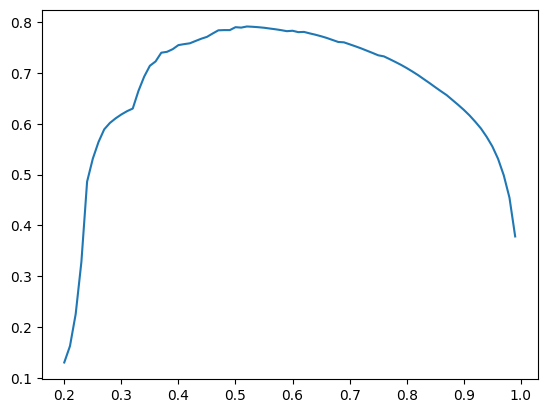

In [56]:
tresholds = np.arange(0.2,1,0.01)
ndice_tr = []
for tr in tresholds:
    ndice_ = []
    for i, v in enumerate(vals):
        ndice_.append(dice_norm_metric(val_pred_means[i],v.cpu().numpy().reshape(128,128), threshold1 = tr))
    ndice_tr.append(np.mean(ndice_))
ndice_tr = np.asarray(ndice_tr)

plt.plot(tresholds, ndice_tr)
plt.show()

In [57]:
tresholds[np.argmax(ndice_tr)]

0.5200000000000002

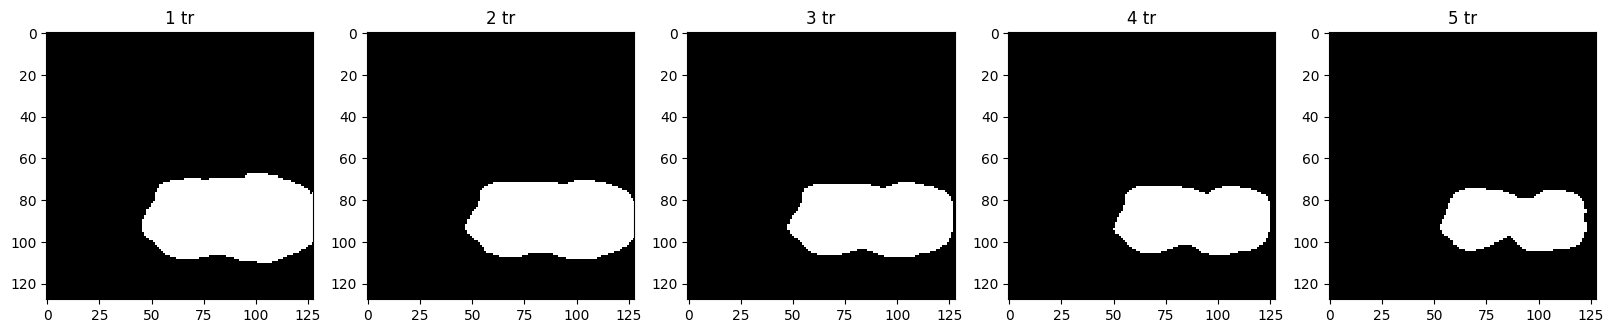

In [162]:
index = 0

plt.figure(figsize=(20,10))
plt.subplot(1,5,1)
plt.imshow(val_pred_means[index]>0.33,interpolation='nearest',cmap='gray')
plt.title("1 tr")
plt.subplot(1,5,2)
plt.imshow(val_pred_means[index]>0.43,interpolation='nearest',cmap='gray')
plt.title("2 tr")
plt.subplot(1,5,3)
plt.imshow(val_pred_means[index]>0.52,interpolation='nearest',cmap='gray')
plt.title("3 tr")
plt.subplot(1,5,4)
plt.imshow(val_pred_means[index]>0.71,interpolation='nearest',cmap='gray')
plt.title("4 tr")
plt.subplot(1,5,5)
plt.imshow(val_pred_means[index]>0.9,interpolation='nearest',cmap='gray')
plt.title("5 tr")
plt.show()

In [144]:
def new_ndice_aula_tr_func(pred, tresh = np.array([0.9, 0.71, 0.52, 0.43, 0.33 ])):
    aula = []
    for j in range(len(pred)):
        aula_curve = [dice_norm_metric(pred[j], pred[j], r = r, threshold1 = tresh[i-1], threshold2 = tresh[i]) for i in range(len(tresh)-1,0,-1)]
        aula.append(np.trapz(aula_curve , dx=1))
    return np.asarray(aula)

In [145]:
def new_area_unc_tr_func(pred, tresh = np.array([0.52, 0.71, 0.9 ])):
    aula = []
    for j in range(len(pred)):
        aula_curve = [np.sum(pred[j]>tr) for tr in tresh]
        aula.append(np.mean(np.asarray(aula_curve)/np.max(aula_curve)) if np.max(aula_curve) != 0 else 1)
    return np.asarray(aula)

In [208]:
def new_ndice_aula_tr_func(pred, tresh = np.array([0.9, 0.71, 0.52, 0.43, 0.33 ])):
    aula = []
    for j in range(len(pred)):
        aula_curve = [dice_norm_metric(pred[j], pred[j], r = r, threshold1 = tresh[i], threshold2 = 0.5) for i in range(len(tresh))]
        aula.append(np.trapz(aula_curve , dx=1))
    return np.asarray(aula)

In [146]:
def new_area_unc_tr_func(pred, tresh = np.array([0.52, 0.71, 0.9 ])):
    aula = []
    for j in range(len(pred)):
        aula_curve = [np.sum(pred[j]>tresh[0])-np.sum(pred[j]>tr) for tr in tresh[1:]]
        aula.append(np.trapz(np.asarray(aula_curve)/np.max(aula_curve), dx=1) if np.max(aula_curve) != 0 else 0)
    return np.asarray(aula)

'def new_area_unc_tr_func(pred, tresh = np.array([0.52, 0.71, 0.9 ])):\n    aula = []\n    for j in range(len(pred)):\n        aula_curve = [np.sum(pred[j]>tresh[0])-np.sum(pred[j]>tr) for tr in tresh[1:]]\n        aula.append(np.trapz(np.asarray(aula_curve)/np.max(aula_curve), dx=1) if np.max(aula_curve) != 0 else 0)\n    return np.asarray(aula)'

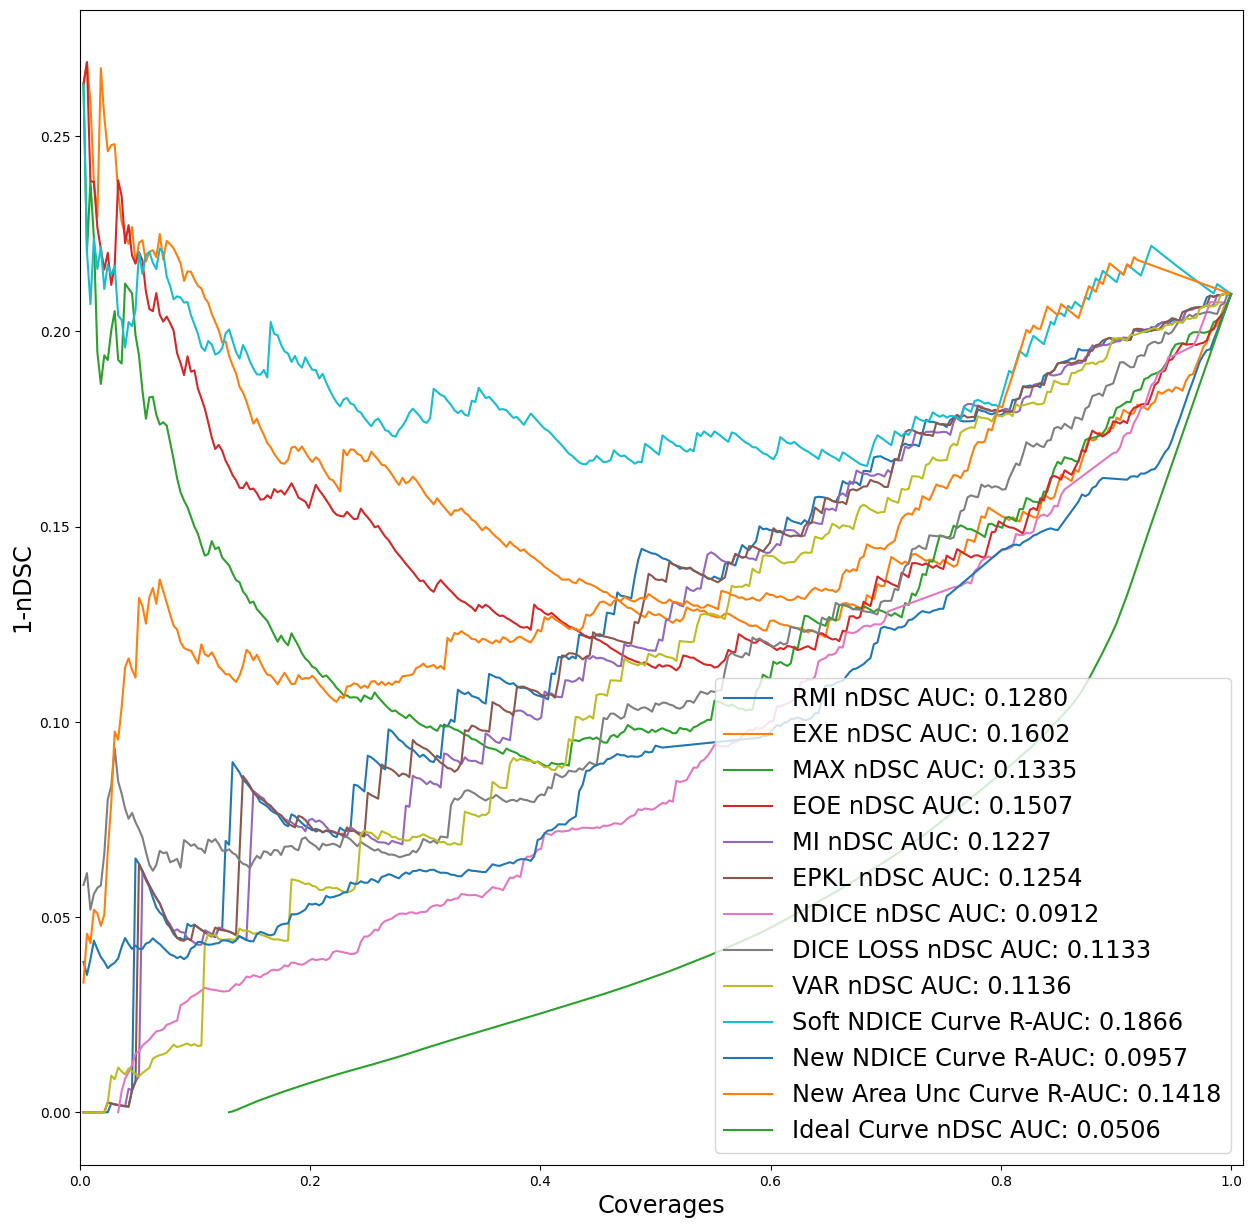

In [209]:
rmi = -1*np.mean(ensemble_uncertainties_classification(vals_uncert[:,:,:,:,:])['reverse_mutual_information'], axis=(1,2))
exe = -1*np.mean(ensemble_uncertainties_classification(vals_uncert[:,:,:,:,:])['expected_entropy'], axis=(1,2))
confidences = np.mean(ensemble_uncertainties_classification(vals_uncert[:,:,:,:,:])['confidence'], axis=(1,2))
eoe = -1*np.mean(ensemble_uncertainties_classification(vals_uncert[:,:,:,:,:])['entropy_of_expected'], axis=(1,2))
mi = -1*np.mean(ensemble_uncertainties_classification(vals_uncert[:,:,:,:,:])['mutual_information'], axis=(1,2))
epkl = -1*np.mean(ensemble_uncertainties_classification(vals_uncert[:,:,:,:,:])['epkl'], axis=(1,2))
aula_ndsc_mean = aula_ndsc_heads_mean_func(vals_pred_e,val_pred_means)
aula_dice_loss_mean = -1*aula_dice_loss_mean_func(vals_pred_e,val_pred_means)
var_uncert = -1*compute_var_func(vals_pred_e,val_pred_means)
aula_soft_dice_loss_mean = aula_soft_ndice_loss_mean_func(vals_pred_e,val_pred_means)
new_ndice_aula = new_ndice_aula_tr_func(val_pred_means, tresh=np.arange(0.2,0.9,0.05))
new_area_unc = new_area_unc_tr_func(val_pred_means, tresh=np.arange(0.3,0.7,0.05))

x1, y1, tr1 = rc_curve(rmi,norm_dices_val)

x2, y2, tr2 = rc_curve(exe,norm_dices_val)

x3, y3, tr3 = rc_curve(confidences,norm_dices_val)

x4, y4, tr4 = rc_curve(eoe,norm_dices_val)

x5, y5, tr5 = rc_curve(mi,norm_dices_val)

x6, y6, tr6 = rc_curve(epkl,norm_dices_val)

x7, y7, tr7 = rc_curve(aula_ndsc_mean,norm_dices_val)

x8, y8, tr8 = rc_curve(aula_dice_loss_mean,norm_dices_val)

x9, y9, tr9 = rc_curve(var_uncert,norm_dices_val)

x10, y10, tr10 = rc_curve(aula_soft_dice_loss_mean,norm_dices_val)

x11, y11, tr11 = rc_curve(new_ndice_aula,norm_dices_val)

x12, y12, tr12 = rc_curve(new_area_unc,norm_dices_val)

x13, y13, tr13 = rc_curve(norm_dices_val,norm_dices_val)


plt.figure(figsize=(15,15))
plt.plot(x1, y1, label=f"RMI nDSC AUC: {metrics.auc(x1, y1):.4f}")
plt.plot(x2, y2, label=f"EXE nDSC AUC: {metrics.auc(x2, y2):.4f}")
plt.plot(x3, y3, label=f"MAX nDSC AUC: {metrics.auc(x3, y3):.4f}")
plt.plot(x4, y4, label=f"EOE nDSC AUC: {metrics.auc(x4, y4):.4f}")
plt.plot(x5, y5, label=f"MI nDSC AUC: {metrics.auc(x5, y5):.4f}")
plt.plot(x6, y6, label=f"EPKL nDSC AUC: {metrics.auc(x6, y6):.4f}")
plt.plot(x7, y7, label=f"NDICE nDSC AUC: {metrics.auc(x7, y7):.4f}")
plt.plot(x8, y8, label=f"DICE LOSS nDSC AUC: {metrics.auc(x8, y8):.4f}")
plt.plot(x9, y9, label=f"VAR nDSC AUC: {metrics.auc(x9, y9):.4f}")
plt.plot(x10, y10, label=f"Soft NDICE Curve R-AUC: {metrics.auc(x10, y10):.4f}")
plt.plot(x11, y11, label=f"New NDICE Curve R-AUC: {metrics.auc(x11, y11):.4f}")
plt.plot(x12, y12, label=f"New Area Unc Curve R-AUC: {metrics.auc(x12, y12):.4f}")
plt.plot(x13, y13, label=f"Ideal Curve nDSC AUC: {metrics.auc(x13, y13):.4f}")
plt.xlabel("Coverages", fontsize = 'xx-large')
plt.ylabel("1-nDSC", fontsize = 'xx-large')
plt.xlim([0.0, 1.01])
plt.legend(fontsize = 'xx-large')
plt.show()

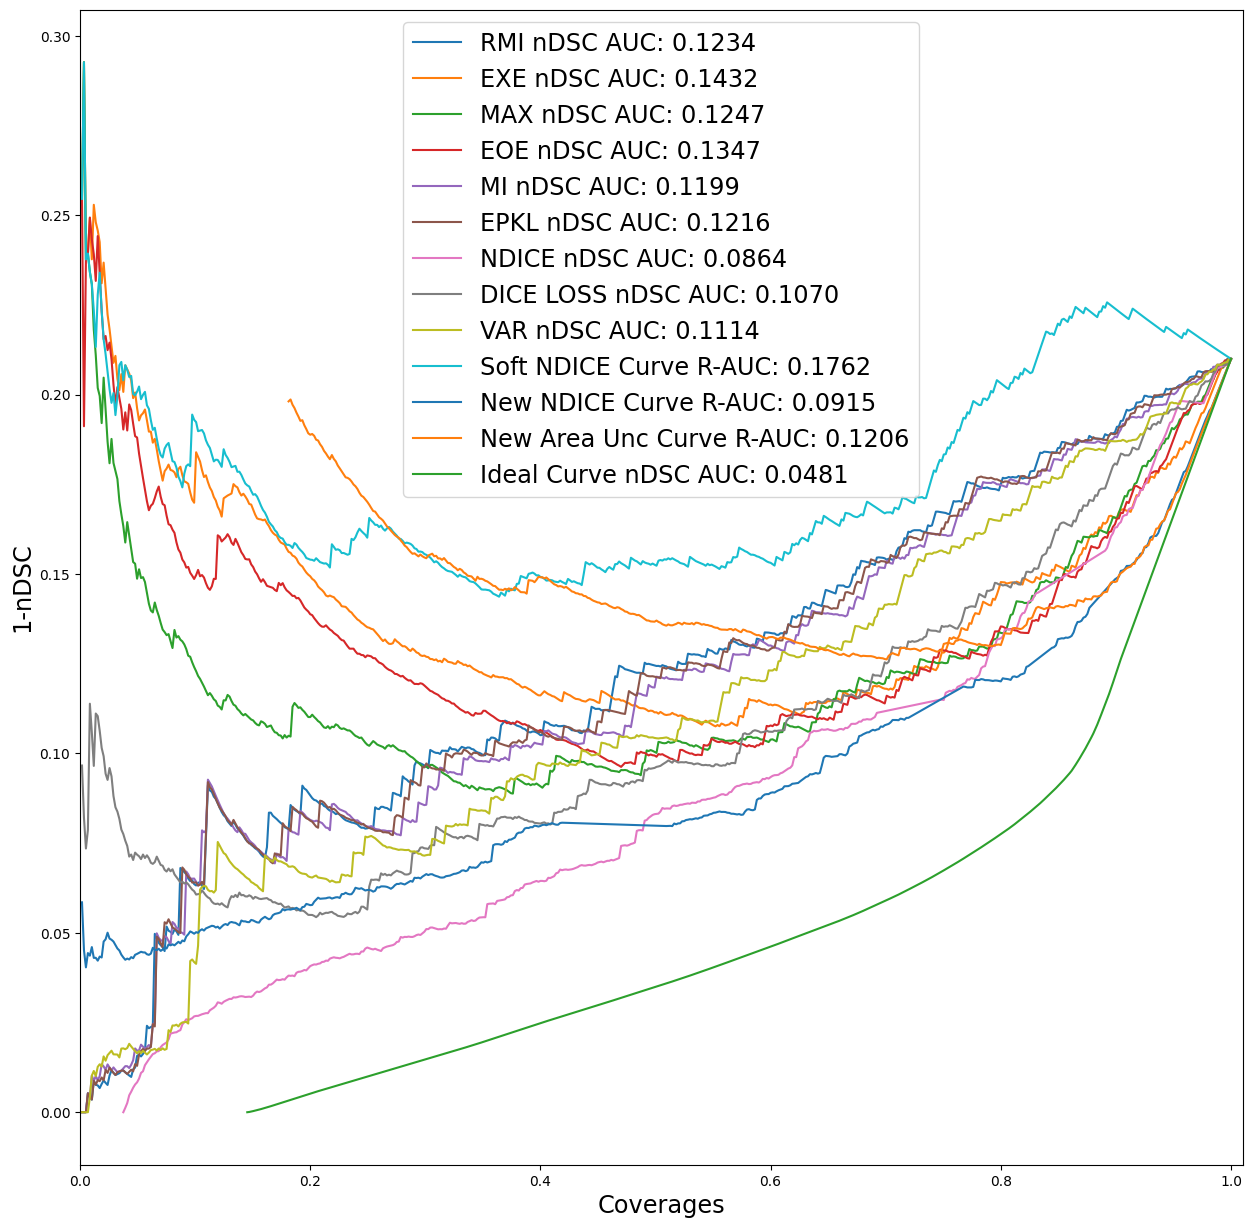

In [165]:
rmi = -1*np.mean(ensemble_uncertainties_classification(tests_uncert[:,:,:,:,:])['reverse_mutual_information'], axis=(1,2))
exe = -1*np.mean(ensemble_uncertainties_classification(tests_uncert[:,:,:,:,:])['expected_entropy'], axis=(1,2))
confidences = np.mean(ensemble_uncertainties_classification(tests_uncert[:,:,:,:,:])['confidence'], axis=(1,2))
eoe = -1*np.mean(ensemble_uncertainties_classification(tests_uncert[:,:,:,:,:])['entropy_of_expected'], axis=(1,2))
mi = -1*np.mean(ensemble_uncertainties_classification(tests_uncert[:,:,:,:,:])['mutual_information'], axis=(1,2))
epkl = -1*np.mean(ensemble_uncertainties_classification(tests_uncert[:,:,:,:,:])['epkl'], axis=(1,2))
aula_ndsc_mean = aula_ndsc_heads_mean_func(tests_pred_e,test_pred_means)
aula_dice_loss_mean = -1*aula_dice_loss_mean_func(tests_pred_e,test_pred_means)
var_uncert = -1*compute_var_func(tests_pred_e,test_pred_means)
aula_soft_dice_loss_mean = aula_soft_ndice_loss_mean_func(tests_pred_e,test_pred_means)
new_ndice_aula = new_ndice_aula_tr_func(test_pred_means, tresh=np.arange(0.2,0.9,0.05))
new_area_unc = new_area_unc_tr_func(test_pred_means, tresh=np.arange(0.5,1.0,0.05))

x1, y1, tr1 = rc_curve(rmi,norm_dices_test)

x2, y2, tr2 = rc_curve(exe,norm_dices_test)

x3, y3, tr3 = rc_curve(confidences,norm_dices_test)

x4, y4, tr4 = rc_curve(eoe,norm_dices_test)

x5, y5, tr5 = rc_curve(mi,norm_dices_test)

x6, y6, tr6 = rc_curve(epkl,norm_dices_test)

x7, y7, tr7 = rc_curve(aula_ndsc_mean,norm_dices_test)

x8, y8, tr8 = rc_curve(aula_dice_loss_mean,norm_dices_test)

x9, y9, tr9 = rc_curve(var_uncert,norm_dices_test)

x10, y10, tr10 = rc_curve(aula_soft_dice_loss_mean,norm_dices_test)

x11, y11, tr11 = rc_curve(new_ndice_aula,norm_dices_test)

x12, y12, tr12 = rc_curve(new_area_unc,norm_dices_test)

x13, y13, tr13 = rc_curve(norm_dices_test,norm_dices_test)


plt.figure(figsize=(15,15))
plt.plot(x1, y1, label=f"RMI nDSC AUC: {metrics.auc(x1, y1):.4f}")
plt.plot(x2, y2, label=f"EXE nDSC AUC: {metrics.auc(x2, y2):.4f}")
plt.plot(x3, y3, label=f"MAX nDSC AUC: {metrics.auc(x3, y3):.4f}")
plt.plot(x4, y4, label=f"EOE nDSC AUC: {metrics.auc(x4, y4):.4f}")
plt.plot(x5, y5, label=f"MI nDSC AUC: {metrics.auc(x5, y5):.4f}")
plt.plot(x6, y6, label=f"EPKL nDSC AUC: {metrics.auc(x6, y6):.4f}")
plt.plot(x7, y7, label=f"NDICE nDSC AUC: {metrics.auc(x7, y7):.4f}")
plt.plot(x8, y8, label=f"DICE LOSS nDSC AUC: {metrics.auc(x8, y8):.4f}")
plt.plot(x9, y9, label=f"VAR nDSC AUC: {metrics.auc(x9, y9):.4f}")
plt.plot(x10, y10, label=f"Soft NDICE Curve R-AUC: {metrics.auc(x10, y10):.4f}")
plt.plot(x11, y11, label=f"New NDICE Curve R-AUC: {metrics.auc(x11, y11):.4f}")
plt.plot(x12, y12, label=f"New Area Unc Curve R-AUC: {metrics.auc(x12, y12):.4f}")
plt.plot(x13, y13, label=f"Ideal Curve nDSC AUC: {metrics.auc(x13, y13):.4f}")
plt.xlabel("Coverages", fontsize = 'xx-large')
plt.ylabel("1-nDSC", fontsize = 'xx-large')
plt.xlim([0.0, 1.01])
plt.legend(fontsize = 'xx-large')
plt.show()